# Snake 10x10

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
import gym_snakegame
import pygame
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline
plt.style.use(['dark_background', 'seaborn-v0_8'])

# Seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch device:", device)

PyTorch device: cuda


## Test the gymnasium env

In [16]:
PLAY_MANUAL = True  # set to False if u wanna see random moves
env = gym.make(
    "gym_snakegame/SnakeGame-v0",
    board_size=5,
    n_channel=1,
    n_target=1,
    render_mode="human"
)

obs, info = env.reset()

KEY_MAP = {
    pygame.K_UP: 2,
    pygame.K_RIGHT: 1,
    pygame.K_DOWN: 0,
    pygame.K_LEFT: 3
}

total_reward = 0
steps = 0

print("hit arrows to play! or close window to quit")
if not PLAY_MANUAL:
    print("auto mode: doing 250 random steps...")

try:
    while True:
        action = None

        if PLAY_MANUAL:
            # wait for key press
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    env.close()
                if event.type == pygame.KEYDOWN:
                    if event.key in KEY_MAP:
                        action = KEY_MAP[event.key]
            if action is None:
                continue  # wait till key pressed
        else:
            if steps >= 250:
                break
            action = env.action_space.sample()
            steps += 1

        # step
        obs, reward, terminated, truncated, info = env.step(action)
        env.render()
        total_reward += reward

        print(
            f"step {steps}/100, score: {total_reward} ({reward} | trunc:{truncated} | trmt:{terminated}) | {info} | {obs}")

        if terminated or truncated:
            print(f"GameOver!  total score: {total_reward}")
            # reset everything
            obs, info = env.reset()
            total_reward = 0
            steps = 0

except KeyboardInterrupt:
    pass
finally:
    env.close()

hit arrows to play! or close window to quit


error: video system not initialized

# Approach 1

In [24]:
class SnakeV0(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128, hidden_layer=2):
        super(SnakeV0, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            *((nn.Linear(hidden_size, hidden_size),
               nn.ReLU()) * hidden_layer),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.net(x)

In [25]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

In [26]:
class DQNAgent:
    def __init__(self, modelclass, state_size, action_size, lr=1e-3, gamma=0.99,
                 buffer_size=50000, batch_size=128, target_update=500, hidden_size=128, hidden_layer=2):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update

        self.q_net = modelclass(state_size, action_size, hidden_size, hidden_layer).to(device)
        self.target_net = modelclass(state_size, action_size, hidden_size, hidden_layer).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.memory = ReplayBuffer(buffer_size)
        self.step_count = 0

    def act(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(state)
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.BoolTensor(dones).to(device)

        current_q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))

        loss = nn.MSELoss()(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())


## utils

In [30]:
def get_head_position(obs):
    """Extract head position (value == 1) from observation (n_channel=1)."""
    grid = obs[0] if obs.ndim == 3 else obs
    pos = np.where(grid == 1)
    if len(pos[0]) > 0:
        return int(pos[0][0]), int(pos[1][0])
    return None


def get_food_position(obs, board_size):
    """Extract food position (value == board_size**2 + 1)."""
    grid = obs[0] if obs.ndim == 3 else obs
    food_val = board_size * board_size + 1
    pos = np.where(grid == food_val)
    if len(pos[0]) > 0:
        return int(pos[0][0]), int(pos[1][0])
    return None


def compute_reward(
        raw_reward,
        terminated,
        snake_length,
        board_size,
        steps_since_last_food,
        current_step,
        prev_obs=None,
        curr_obs=None
):
    """
    Compute shaped reward with proximity bonus.
    
    Args:
        raw_reward: reward from env (usually +1 for food)
        terminated: bool
        snake_length: int
        board_size: int
        steps_since_last_food: int
        current_step: int
        prev_obs: previous observation (for head position)
        curr_obs: current observation (for head and food position)
    """
    max_len = board_size * board_size

    # Win condition
    if snake_length == max_len:
        return 100.0

    # Death penalty
    if terminated:
        return -10.0

    reward = 0.0

    # Food reward
    if raw_reward > 0:
        reward += 5.0

    # Proximity reward (only if we have observation data)
    if curr_obs is not None:
        head_pos = get_head_position(curr_obs)
        food_pos = get_food_position(curr_obs, board_size)
        if head_pos is not None and food_pos is not None:
            # Manhattan distance (works well on grid)
            dist = abs(head_pos[0] - food_pos[0]) + abs(head_pos[1] - food_pos[1])
            # Inverse distance reward: higher when closer
            # Max distance on board is 2*(board_size-1), so min reward ~0.1
            reward += 0.5 / (dist + 1)

    # todo: survival reward based on snake length

    # Survival bonus
    reward += 0.2

    # Mild step penalty
    reward -= 0.005

    # Looping penalty (only after reasonable time)
    if steps_since_last_food >= max_len and current_step > 100:
        reward -= 0.5

    return reward


def format_number_with_spaces(n):
    """Format large episode numbers with spaces as thousand separators."""
    return f"{n:,}".replace(",", " ")


def get_snake_length(obs, board_size):
    """Count number of snake cells in observation (n_channel=1)."""
    # obs shape: (1, H, W) or (H, W) — handle both
    grid = obs[0] if obs.ndim == 3 else obs
    max_body_val = board_size * board_size
    # Snake cells: values from 1 to max_body_val
    return np.sum((grid >= 1) & (grid <= max_body_val))


def train_dqn(
        modelclass,
        board_size=10,
        env_name="gym_snakegame/SnakeGame-v0",
        episodes=20000,
        max_steps=500,
        plot_live=False
):
    env = gym.make(
        env_name,
        board_size=board_size,
        n_channel=1,
        n_target=1,
        render_mode=None
    )
    state_size = np.prod(env.observation_space.shape)
    action_size = env.action_space.n
    agent = DQNAgent(
        modelclass=modelclass,
        state_size=state_size,
        action_size=action_size,
        lr=1e-4,
        gamma=0.95,
        buffer_size=20_000,
        batch_size=64,
        target_update=300,
        hidden_size=256,
        hidden_layer=4,
    )

    # Tracking metrics
    recent_rewards = deque(maxlen=100)
    recent_steps = deque(maxlen=100)
    recent_lengths = deque(maxlen=100)

    # For plotting
    episode_log = []
    epsilon_log = []
    reward_stats_log = []  # [min, q25, med, q75, max]
    steps_stats_log = []
    length_stats_log = []

    epsilon = 1.0
    epsilon_decay = 0.9995
    epsilon_end = 0.05
    max_steps_without_food = board_size * board_size

    print("Starting training...")
    for episode in range(episodes):
        obs, _ = env.reset()
        state = obs.flatten().astype(np.float32)
        total_reward = 0.0
        steps = 0
        steps_since_last_food = 0
        prev_length = int(get_snake_length(obs, board_size))

        for t in range(max_steps):
            action = agent.act(state, epsilon)
            next_obs, raw_reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            curr_length = int(get_snake_length(next_obs, board_size))
            ate_food = (curr_length > prev_length)

            if ate_food:
                steps_since_last_food = 0
            else:
                steps_since_last_food += 1

            reward = compute_reward(
                raw_reward=raw_reward,
                terminated=terminated,
                snake_length=curr_length,
                board_size=board_size,
                steps_since_last_food=steps_since_last_food,
                current_step=t
            )

            next_state = next_obs.flatten().astype(np.float32)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()

            state = next_state
            total_reward += reward
            prev_length = curr_length
            steps += 1

            if done:
                break

        final_length = curr_length
        recent_rewards.append(total_reward)
        recent_steps.append(steps)
        recent_lengths.append(final_length)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        # Log every 100 episodes
        if (episode + 1) % 100 == 0:
            rewards = np.array(recent_rewards)
            steps_arr = np.array(recent_steps)
            lengths_arr = np.array(recent_lengths)

            r_min, r_q25, r_med, r_q75, r_max = np.percentile(rewards, [0, 25, 50, 75, 100])
            s_min, s_q25, s_med, s_q75, s_max = np.percentile(steps_arr, [0, 25, 50, 75, 100])
            l_min, l_q25, l_med, l_q75, l_max = np.percentile(lengths_arr, [0, 25, 50, 75, 100])

            ep_str = f"{episode:,}".replace(",", " ")
            print(
                f"Episode {ep_str:>12} | "
                f"R (last 100): {r_min:+7.3f} / {r_q25:+7.3f} / {r_med:+7.3f} / {r_q75:+7.3f} / {r_max:+7.3f} | "
                f"Steps: {s_min:5.0f} / {s_q25:5.0f} / {s_med:5.0f} / {s_q75:5.0f} / {s_max:5.0f} | "
                f"Epsilon: {epsilon:6.3f}"
            )

            # Store for plotting
            episode_log.append(episode)
            epsilon_log.append(epsilon)
            reward_stats_log.append([r_min, r_q25, r_med, r_q75, r_max])
            steps_stats_log.append([s_min, s_q25, s_med, s_q75, s_max])
            length_stats_log.append([l_min, l_q25, l_med, l_q75, l_max])

            # Real-time plot
            if plot_live:
                clear_output(wait=True)
                fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

                episodes_plot = np.array(episode_log)

                # Epsilon
                axs[0].plot(episodes_plot, epsilon_log, 'b-', label='Epsilon')
                axs[0].set_ylabel('Epsilon')
                axs[0].grid(True)
                axs[0].legend()

                # Reward
                reward_arr = np.array(reward_stats_log)
                axs[1].fill_between(episodes_plot, reward_arr[:, 0], reward_arr[:, 4], color='lightcoral', alpha=0.3)
                axs[1].fill_between(episodes_plot, reward_arr[:, 1], reward_arr[:, 3], color='lightcoral', alpha=0.5)
                axs[1].plot(episodes_plot, reward_arr[:, 2], 'r-', label='Reward (median)')
                axs[1].set_ylabel('Reward')
                axs[1].grid(True)
                axs[1].legend()

                # Steps
                steps_arr_plot = np.array(steps_stats_log)
                axs[2].fill_between(episodes_plot, steps_arr_plot[:, 0], steps_arr_plot[:, 4], color='lightgreen',
                                    alpha=0.3)
                axs[2].fill_between(episodes_plot, steps_arr_plot[:, 1], steps_arr_plot[:, 3], color='lightgreen',
                                    alpha=0.5)
                axs[2].plot(episodes_plot, steps_arr_plot[:, 2], 'g-', label='Steps (median)')
                axs[2].set_ylabel('Steps')
                axs[2].grid(True)
                axs[2].legend()

                # Snake Length
                length_arr = np.array(length_stats_log)
                axs[3].fill_between(episodes_plot, length_arr[:, 0], length_arr[:, 4], color='lightblue', alpha=0.3)
                axs[3].fill_between(episodes_plot, length_arr[:, 1], length_arr[:, 3], color='lightblue', alpha=0.5)
                axs[3].plot(episodes_plot, length_arr[:, 2], 'b-', label='Length (median)')
                axs[3].set_ylabel('Final Snake Length')
                axs[3].set_xlabel('Episode')
                axs[3].grid(True)
                axs[3].legend()

                plt.tight_layout()
                plt.show()

    env.close()
    return agent


def evaluate_agent(agent, board_size=10, episodes=10, max_steps=500):
    env = gym.make(
        "gym_snakegame/SnakeGame-v0",
        board_size=board_size,
        n_channel=1,
        n_target=1,
        render_mode="human"
    )
    total_reward = 0.0
    for _ in range(episodes):
        obs, info = env.reset()
        state = obs.flatten().astype(np.float32)
        prev_length = info.get('snake_length', 1)

        for _ in range(max_steps):
            action = agent.act(state, epsilon=0.0)
            obs, raw_reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = obs.flatten().astype(np.float32)
            if done:
                break

    env.close()

## Training loop

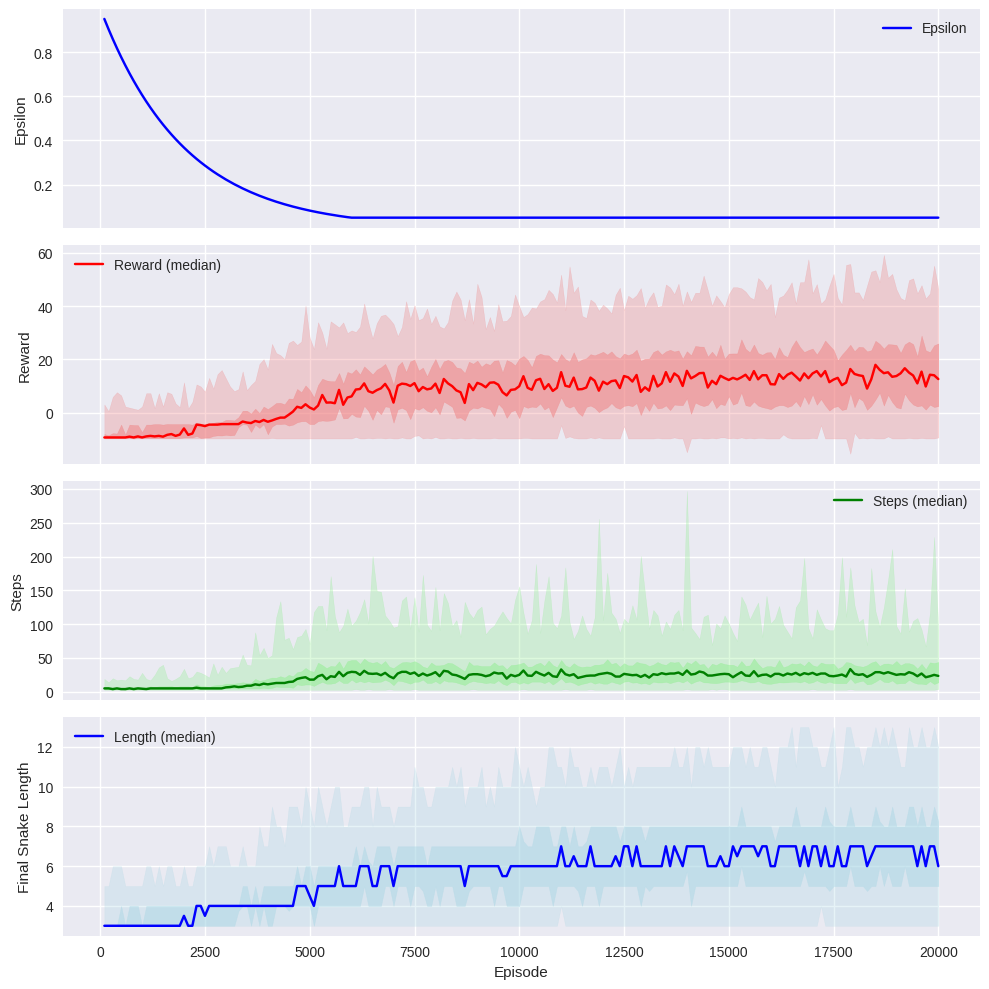

In [31]:
agent = train_dqn(modelclass=SnakeV0, board_size=5, episodes=20000, max_steps=2_000, plot_live=True)

In [29]:
# evaluate_agent(trained_agent, board_size=10, episodes=10)
eval_env = gym.make("gym_snakegame/SnakeGame-v0",
                    board_size=10,
                    n_channel=1,
                    n_target=1,
                    render_mode="human")
evaluate_agent(agent, eval_env, episodes=200)
eval_env.close()

TypeError: '>=' not supported between instances of 'OrderEnforcing' and 'int' was raised from the environment creator for gym_snakegame/SnakeGame-v0 with kwargs ({'board_size': <OrderEnforcing<PassiveEnvChecker<SnakeGameEnv<gym_snakegame/SnakeGame-v0>>>>, 'n_channel': 1, 'n_target': 1, 'render_mode': 'human'})